# Distributed Optimization on Hadamard Manifolds

This notebook implements decentralized projected Riemannian gradient descent (DPRGD) in decentralized Frechet mean computation problems. Our experiments consider two Hadamard manifolds, hyperbolic spaces and the space of symmetric positive definite (SPD) matrices. For each setting, we evaluate both DPRGD and iDPRGD in terms of dynamic regret and computational efficiency.

In [1]:
import sys
import os
sys.path.append(os.path.abspath("src"))

import numpy as np
import matplotlib.pyplot as plt 
from utils import hyperboloid, spd
import time

## Hyperbolic Spaces $\mathbb{H}^2$
Now we consider a network of $n=30$ agents, each agent is connected to its nearest 4 neighbors. The weight matrix W is constructed from the Metropolis constant edge weight matrix. In other words, $w_{ij} = 1/5$ if $i=j$ or $i$ and $j$ are connected, otherwise $w_{ij}=0$.

In [65]:
n = 30 # number of agents
K = 50 # number of samples at each node
dim = 2 # dimension of the hyperbolic space

### Static Setting

We generate $z_i$ from the Riemannian Gaussian distribution with base $\alpha=(1,0,0)$ in the hyperboloid model and $\sigma=1$. Then we draw $\{z_{ik}\}_{k=1}^K$ from the Riemannian Gaussian distribution with base $z_{i}$ and $\sigma=0.25$.

In [66]:
base = np.array([1, 0, 0])
base_agent = hyperboloid.random_riemannian_gaussian(base, n_samples = n, sigma = 1)
data = np.zeros((n, K, dim + 1))
for i in range(n):
    data[i] = hyperboloid.random_riemannian_gaussian(base_agent[i], n_samples = K, sigma = 0.25)
full_data = data.reshape(n * K, dim + 1)
global_mean = hyperboloid.frechet_mean(full_data, max_iter = 200, tol = 1e-8) # global minimizer

In [67]:
def visualize(data, ax = None, transform_to_poincare_ball = True): 
    """Visualize the data on the H2"""
    if transform_to_poincare_ball: 
        data = hyperboloid.hyperboloid_to_poincare_ball(data)

    circle = plt.Circle((0, 0), 1, fill = False, edgecolor = 'black', lw = 2) 
    ax.add_patch(circle) 
    ax.scatter(data[:, 0], data[:, 1], color = 'black', s = 40, label = 'Local states') 
    ax.axis('equal') 
    ax.set_xlim(-1.02, 1.02) 
    ax.set_ylim(-1.02, 1.02) 
    ax.axis('off') 
    return ax

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

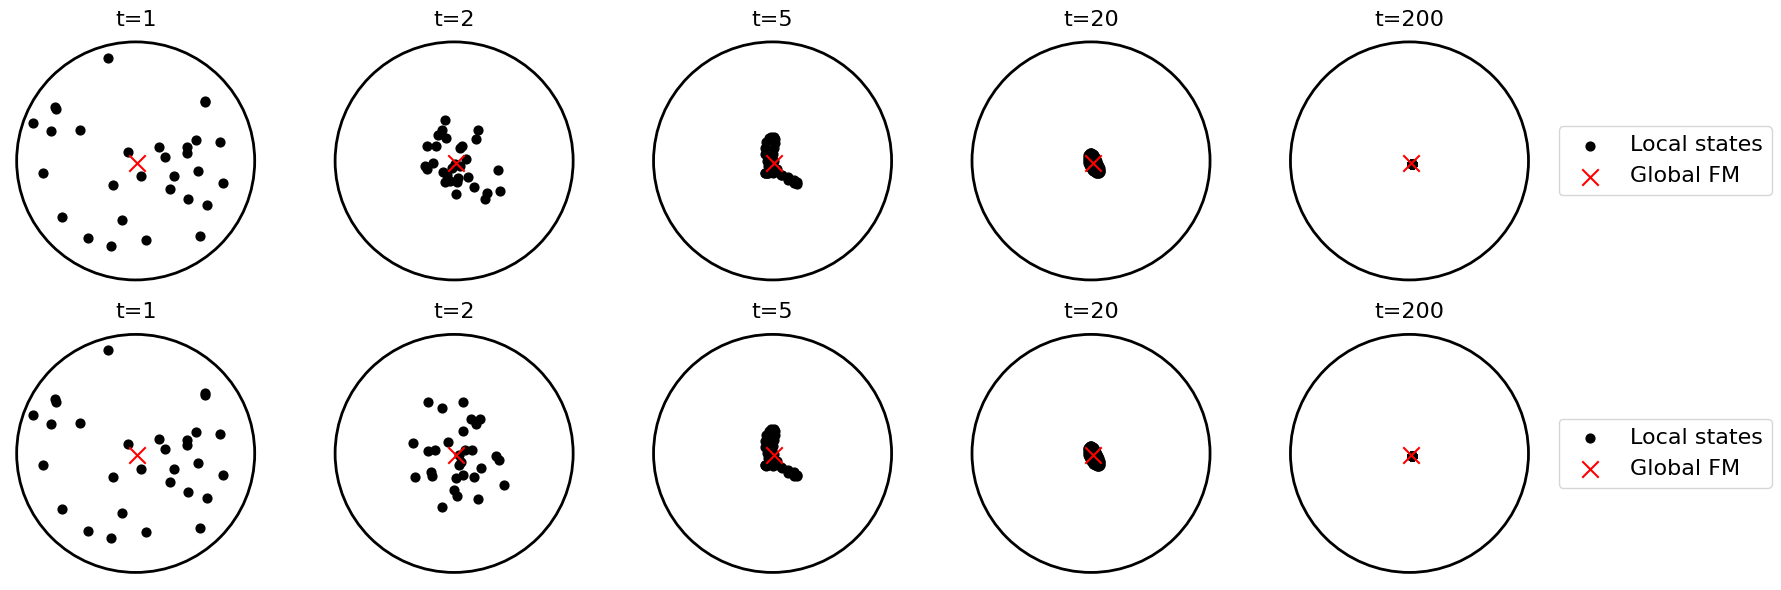

In [68]:
fig, axs = plt.subplots(2, 6, figsize = (18, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 0.5]})

state = np.zeros((n, dim + 1))
state_iDPRGD = np.zeros((n, dim + 1))
for i in range(n):
    state[i] = hyperboloid.frechet_mean(data[i]) # initial state using local frechet means
    state_iDPRGD[i] = state[i]

global_mean_poincare = hyperboloid.hyperboloid_to_poincare_ball(global_mean)

ax = visualize(state, ax = axs[0, 0])
ax.scatter(global_mean_poincare[0], global_mean_poincare[1], color = 'red', marker = 'x', s = 140, label = 'Global FM')
ax.set_title("t=1", fontsize = 16)
ax = visualize(state_iDPRGD, ax = axs[1, 0])
ax.scatter(global_mean_poincare[0], global_mean_poincare[1], color = 'red', marker = 'x', s = 140, label = 'Global FM')
ax.set_title("t=1", fontsize = 16)
T = 200
stepsize = 0.0001
gamma = 1

t_list = [0, 3, 18, 198]

for t in range(T):

    state_new = np.zeros((n, dim + 1))
    state_iDPRGD_new = np.zeros((n, dim + 1))

    for i in range(n):
        start = (i - 2) % n
        end = (i + 2) % n

        if start < end:
            neighbors_index = list(range(start, end + 1))
        else:
            neighbors_index = list(range(start, n)) + list(range(end + 1))

        state_new[i] = hyperboloid.frechet_mean(state[neighbors_index])
        vector = np.mean(hyperboloid.log(state_iDPRGD[i], state[neighbors_index]), axis = 0)
        state_iDPRGD_new[i] = hyperboloid.exp(state_iDPRGD[i], gamma * vector)

    for i in range(n):
        minus_gradient = np.mean(hyperboloid.log(state_new[i], data[i]), axis = 0)
        state[i] = hyperboloid.exp(state_new[i], stepsize * minus_gradient)
        minus_gradient_iDPRGD = np.mean(hyperboloid.log(state_iDPRGD_new[i], data[i]), axis = 0)
        state_iDPRGD[i] = hyperboloid.exp(state_iDPRGD_new[i], stepsize * minus_gradient_iDPRGD)

    if t == 0 or t == 3 or t == 18 or t == 198:
        ind = t_list.index(t)
        ax = visualize(state, ax = axs[0, ind + 1])
        ax.scatter(global_mean_poincare[0], global_mean_poincare[1], color = 'red', marker = 'x', s = 140, label = 'Global FM')
        ax.set_title("t={}".format(t + 2), fontsize = 16)
        ax = visualize(state_iDPRGD, ax = axs[1, ind + 1])
        ax.scatter(global_mean_poincare[0], global_mean_poincare[1], color = 'red', marker = 'x', s = 140, label = 'Global FM') 
        ax.set_title("t={}".format(t + 2), fontsize = 16)
    
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[0, -1].legend(handles, labels, loc = 'center', fontsize = 16)
axs[0, -1].axis('off')
axs[1, -1].legend(handles, labels, loc = 'center', fontsize = 16)
axs[1, -1].axis('off')

plt.tight_layout()
plt.savefig("figure/consensus_hyperboloid.pdf")
plt.show()



### Dynamic Setting

Let $T=100$. Assume $\{f_{i,t}\}$ change abruptly in the first 100 steps and change gradually in the remaining steps. 

For $t\leq 50$, we let $\{f_{i,t}\}$ change every $T_0$ epochs, where $T_0\in\{10,20,40\}$ represents the levels of nonstationarity. When $t/T_0$ is an odd integer, we draw $\{z_i^t\}$ from  RN($\alpha$, $\sigma$) with $\alpha=(3,2,2)$, $\sigma=1$. Then we generate $\{z_{ik}^t\}$ from RN($z_i^t$, $0.25$). These $\{z_{ik}^t\}$ remain the same until $t/T_0$ reaches next integer. When $t/T_0$ is an even integer, we draw $\{z_i^t\}$ from RN($(1,0,0)$, $2$). Then we generate $\{z_{ik}^t\}$ from the RN($z_i^t$, $0.25$). These $\{z_{ik}^t\}$ remain unchanged until $t/T_0$ reaches next integer.


For $t> 50$, we express each $t=sT_0+r$ with nonnegative integers $s$ and $r$. At time $t$, we set base as $\cosh(r/T_0)(1,0,0)+\sinh(r/T_0)(0,1/\sqrt{2},1/\sqrt{2})$. Then we draw samples $\{z_i^t\}$ from the Riemannian Gaussian distribution with this base and $\sigma=1$. Next, we draw $\{z_{ik}\}$ from the Riemannian radial distribution with $\alpha=z_i^t$ and $\sigma=0.25$.

In [69]:
T = 100
T0_candidate = np.array([5, 20])
stepsize = 0.05
gamma = 1

dynamic_regret = np.zeros((len(T0_candidate), T))
runtime = np.zeros((len(T0_candidate), T))
dynamic_regret_iDPRGD = np.zeros((len(T0_candidate), T))
runtime_iDPRGD = np.zeros((len(T0_candidate), T))

data = np.zeros((len(T0_candidate), T, n, K, dim + 1))
loss_global = np.zeros((len(T0_candidate), T))

output_dir = "data/cache/hyperboloid"

In [ ]:
# load cached data
data = np.load("{}/data.npy".format(output_dir))
loss_global = np.load("{}/loss_global.npy".format(output_dir))
dynamic_regret = np.load("{}/dynamic_regret.npy".format(output_dir))
runtime = np.load("{}/runtime.npy".format(output_dir))
dynamic_regret_iDPRGD = np.load("{}/dynamic_regret_iDPRGD.npy".format(output_dir))
runtime_iDPRGD = np.load("{}/runtime_iDPRGD.npy".format(output_dir))

In [70]:
for s in range(len(T0_candidate)):
    T0 = T0_candidate[s]
    for t in range(T):

        if t < 100:
            if t % T0 == 0: # generate new data
                if (t // T0) % 2 == 0:
                    base = np.array([1, 0, 0])
                else:
                    base = np.array([3, 2, 2])

                base_agent = hyperboloid.random_riemannian_gaussian(base, n_samples = n, sigma = 1)

                for i in range(n):
                    data[s, t, i, ...] = hyperboloid.random_riemannian_gaussian(base_agent[i], n_samples = K, sigma = 0.25)
                
                full_data = data[s, t, ...].reshape(n * K, dim + 1)
                global_mean = hyperboloid.frechet_mean(full_data)
                loss_global[s, t] = np.mean(hyperboloid.dist(global_mean, full_data) ** 2)

            else: # data remains the same
                data[s, t, ...] = data[s, t - 1, ...]
                loss_global[s, t] = loss_global[s, t - 1]  

        else:
            r = t % T0
            base = np.array([1, 0, 0]) * np.cosh(r / T0) + np.array([0, 1 / np.sqrt(2), 1 / np.sqrt(2)]) * np.sinh(r / T0)
            base_agent = hyperboloid.random_riemannian_gaussian(base, n_samples = n, sigma = 1)
            
            for i in range(n):
                data[s, t, i, ...] = hyperboloid.random_riemannian_gaussian(base_agent[i], n_samples = K, sigma = 0.25)

            full_data = data[s, t, ...].reshape(n * K, dim + 1)
            global_mean = hyperboloid.frechet_mean(full_data)
            loss_global[s, t] = np.mean(hyperboloid.dist(global_mean, full_data) ** 2)

# save data
#np.save(output_dir + "/data.npy", data)
#np.save(output_dir + "/loss_global.npy", loss_global)

In [73]:
# DPRGD

state = np.zeros((n, dim + 1))
for s in range(len(T0_candidate)):
    start_time = time.time()
    for t in range(T):
        if t == 0:
            for i in range(n):
                state[i] = hyperboloid.frechet_mean(data[s, t, i, ...]) # initial state using local frechet means

        # evaluate the local loss
        loss_local = np.zeros(n)
        full_data = data[s, t, ...].reshape(n * K, dim + 1)
        for i in range(n):
            loss_local[i] = np.mean(hyperboloid.dist(state[i], full_data) ** 2)
        dynamic_regret[s, t] = np.mean(loss_local) - loss_global[s, t] + (t > 0) * dynamic_regret[s, t - 1] 

        end_time = time.time()
        runtime[s, t] = end_time - start_time

        state_new = np.zeros((n, dim + 1))
        for i in range(n):
            start = (i - 2) % n
            end = (i + 2) % n
            if start < end:
                neighbors_index = list(range(start, end + 1))
            else:
                neighbors_index = list(range(start, n)) + list(range(end + 1))
            state_new[i] = hyperboloid.frechet_mean(state[neighbors_index])

        for i in range(n):
            minus_gradient = np.mean(hyperboloid.log(state_new[i], data[s, t, i, ...]), axis = 0)
            state[i] = hyperboloid.exp(state_new[i], stepsize * minus_gradient)

# save the results
#np.save(output_dir + "/regret_DPRGD.npy", dynamic_regret)
#np.save(output_dir + "/runtime_DPRGD.npy", runtime)

In [74]:
# iDPRGD 
state_iDPRGD = np.zeros((n, dim + 1))

for s in range(len(T0_candidate)):
    start_time = time.time()
    for t in range(T):
        # initialization only at time t = 0
        if t == 0:
            for i in range(n):
                state_iDPRGD[i] = hyperboloid.frechet_mean(data[s, t, i, ...]) # initial state_iDPRGD using local frechet means

        loss_local = np.zeros(n)
        full_data = data[s, t, ...].reshape(n * K, dim + 1)
        for i in range(n):
            loss_local[i] = np.mean(hyperboloid.dist(state_iDPRGD[i], full_data) ** 2)
        dynamic_regret_iDPRGD[s, t] = np.mean(loss_local) - loss_global[s, t] + (t > 0) * dynamic_regret_iDPRGD[s, t - 1] 

        end_time = time.time()
        runtime_iDPRGD[s, t] = end_time - start_time

        state_iDPRGD_new = np.zeros((n, dim + 1))

        for i in range(n):
            start = (i - 2) % n
            end = (i + 2) % n
            if start < end:
                neighbors_index = list(range(start, end + 1))
            else:
                neighbors_index = list(range(start, n)) + list(range(end + 1))
            vector = np.mean(hyperboloid.log(state_iDPRGD[i], state_iDPRGD[neighbors_index]), axis = 0)
            state_iDPRGD_new[i] = hyperboloid.exp(state_iDPRGD[i], gamma * vector)

        # gradient step

        for i in range(n):
            minus_gradient = np.mean(hyperboloid.log(state_iDPRGD_new[i], data[s, t, i, ...]), axis = 0) 
            state_iDPRGD[i] = hyperboloid.exp(state_iDPRGD_new[i], stepsize * minus_gradient) 

# save the results
#np.save(output_dir + "/regret_iDPRGD.npy", dynamic_regret_iDPRGD)
#np.save(output_dir + "/runtime_iDPRGD.npy", runtime_iDPRGD)

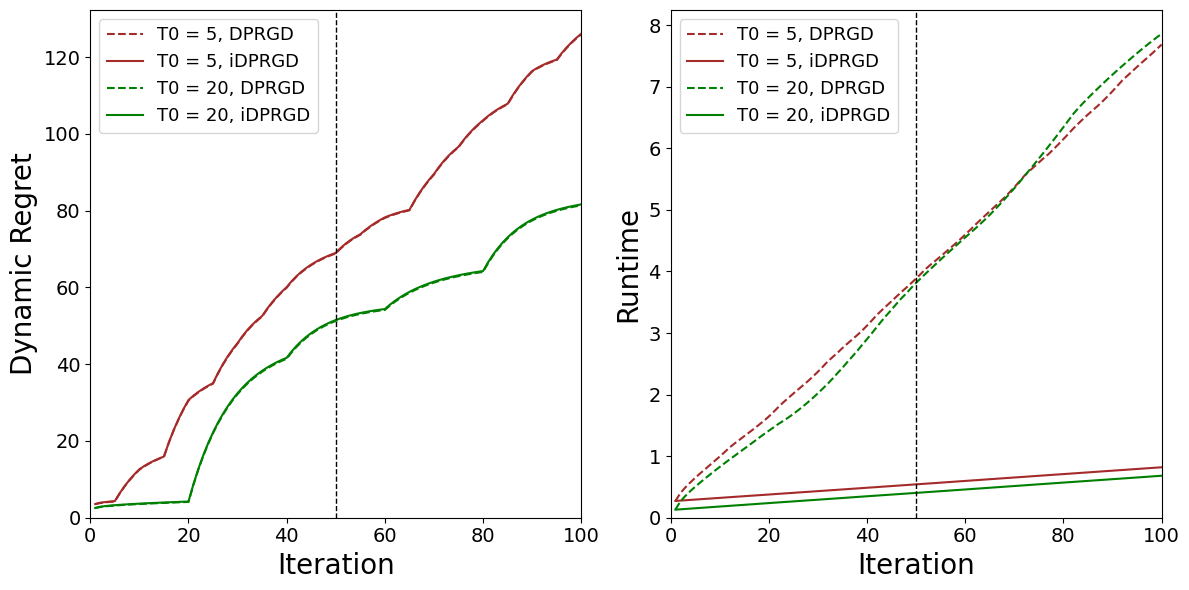

In [80]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

colors = ['brown', 'green', 'red']

ax = axs[0] 

for s in range(len(T0_candidate)):
    ax.plot(np.arange(1, T+1), dynamic_regret[s], label = 'T0 = ' + str(T0_candidate[s]) + ', DPRGD', linestyle = '--', color = colors[s])
    ax.plot(np.arange(1, T+1), dynamic_regret_iDPRGD[s], label = 'T0 = ' + str(T0_candidate[s]) + ', iDPRGD', linestyle = '-', color = colors[s])

ax.legend(fontsize = 13)
ax.set_xlabel('Iteration', fontsize = 20)
ax.set_ylabel('Dynamic Regret', fontsize = 20)  
ax.set_ylim(0, None) 
ax.set_xlim(0, 100)
ax.tick_params(axis = 'both', labelsize = 14)  
ax.axvline(x = 50, color='black', linestyle='--', alpha = 1, lw = 1)

ax = axs[1] 

for s in range(len(T0_candidate)):
    ax.plot(np.arange(1, T+1), runtime[s], label = 'T0 = ' + str(T0_candidate[s]) + ', DPRGD', linestyle = '--', color = colors[s])
    ax.plot(np.arange(1, T+1), runtime_iDPRGD[s], label = 'T0 = ' + str(T0_candidate[s]) + ', iDPRGD', linestyle = '-', color = colors[s])

ax.legend(fontsize = 13)
ax.set_xlabel('Iteration', fontsize = 20)
ax.set_ylabel('Runtime', fontsize = 20)  
ax.set_ylim(0, None) 
ax.set_xlim(0, 100)
ax.tick_params(axis = 'both', labelsize = 14) 
ax.axvline(x = 50, color='black', linestyle='--', alpha = 1, lw = 1)

plt.tight_layout()
plt.savefig('figure/hyperboloid.pdf')
plt.show()

### Symmetric Positive Definite Matrices

In the following experiment, we consider a network of $n=8$ agents, each agent is connected to its nearest 4 neighbors. The weight matrix W is constructed from the Metropolis constant edge weight matrix. In other words, $w_{ij} = 1/5$ if $i=j$ or $i$ and $j$ are connected, otherwise $w_{ij}=0$.

Consider $T=60$ and $T_0\in\{4, 15\}$.

For the first 30 steps, we assume $\{f_{it}\}$ change abruptly. When $t/T_0$ is an odd integer, we draw $Z_i^t\sim{\rm Exp}_I(V)$ where $V$ is a symmetric matrix with ${\cal U}(0,0.1)$ entries. Then we draw $\{Z_{ik}^t\}\sim{\rm Exp}_{Z_i^t}(V)$ where $V$ is a symmetric matrix with ${\cal U}(0,0.1)$ entries. When $t/T_0$ is an even integer, we repeat the above procedure except that we replace $I$ by $3I$.

For the rest steps, we assume $\{f_{it}\}$ change abruptly and gradually. We let $t=sT_0+r$ with nonnegative integers $s$ and $r$. Then at time $t$, we draw $Z_i^t\sim{\rm Exp}_{(1+2 r/T_0)I}(V)$ where symmetric $V$ contains ${\cal U}(0,0.1)$ entries. Then we draw $\{Z_{ik}^t\}\sim{\rm Exp}_{Z_{i}^t}(V)$ where $V$ is a symmetric matrix with ${\cal U}(0,0.1)$ entries. 

In [81]:
n = 8 # number of agents
K = 15 # number of samples at each node
dim = 3 # consider 3 by 3 symmetric positive definite matrices
T = 60
T0_candidate = np.array([4, 15])
stepsize = 0.1
gamma = 1

dynamic_regret = np.zeros((len(T0_candidate), T))
runtime = np.zeros((len(T0_candidate), T))
dynamic_regret_iDPRGD = np.zeros((len(T0_candidate), T))
runtime_iDPRGD = np.zeros((len(T0_candidate), T))

data = np.zeros((len(T0_candidate), T, n, K, dim, dim))
loss_global = np.zeros((len(T0_candidate), T))

output_dir = "data/cache/spd"

In [ ]:
# load cached data
data = np.load("{}/data.npy".format(output_dir))
loss_global = np.load("{}/loss_global.npy".format(output_dir))
dynamic_regret = np.load("{}/dynamic_regret.npy".format(output_dir))
runtime = np.load("{}/runtime.npy".format(output_dir))
dynamic_regret_iDPRGD = np.load("{}/dynamic_regret_iDPRGD.npy".format(output_dir))
runtime_iDPRGD = np.load("{}/runtime_iDPRGD.npy".format(output_dir))

In [82]:
for s in range(len(T0_candidate)):
    T0 = T0_candidate[s]
    for t in range(T):
        if t < 30:
            if t % T0 == 0: # generate new data
                if (t // T0) % 2 == 0:
                    base = np.eye(dim)
                else:
                    base = 3 * np.eye(dim)
                base_agent = spd.random(base, n_samples = n, radius = 0.1)

                for i in range(n):
                    data[s, t, i, ...] = spd.random(base_agent[i], n_samples = K, radius = 0.1)

                full_data = data[s, t, ...].reshape(n * K, dim, dim)
                global_mean = spd.frechet_mean(full_data)
                loss_global[s, t] = np.mean(spd.dist(global_mean, full_data) ** 2)
            
            else:
                data[s, t, ...] = data[s, t - 1, ...] 
                loss_global[s, t] = loss_global[s, t - 1]

        else:
            r = t % T0
            base = np.eye(dim) * (1 + r / T0 * 2)
            base_agent = spd.random(base, n_samples = n, radius = 0.1)

            for i in range(n):
                data[s, t, i, ...] = spd.random(base_agent[i], n_samples = K, radius = 0.1)
            full_data = data[s, t, ...].reshape(n * K, dim, dim)
            global_mean = spd.frechet_mean(full_data)
            loss_global[s, t] = np.mean(spd.dist(global_mean, full_data) ** 2)

# save the data
np.save(output_dir + "/data.npy", data)
np.save(output_dir + "/loss_global.npy", loss_global)

In [83]:
# DPRGD

state = np.zeros((n, dim, dim))
for s in range(len(T0_candidate)):

    T0 = T0_candidate[s]
    start_time = time.time()

    for t in range(T): 
        if t == 0:
            for i in range(n):
                state[i] = data[s, t, i][0] # initial state using the first sample
 
        loss_local = np.zeros(n)
        full_data = data[s, t, ...].reshape(n * K, dim, dim)
        for i in range(n):
            loss_local[i] = np.mean(spd.dist(state[i], full_data) ** 2)
        if t == 0:
            dynamic_regret[s, t] = np.mean(loss_local) - loss_global[s, t]
        else:
            dynamic_regret[s, t] = dynamic_regret[s, t - 1] + np.mean(loss_local) - loss_global[s, t]

        end_time = time.time()
        runtime[s, t] = end_time - start_time

        state_new = np.zeros((n, dim, dim))

        for i in range(n):
            start = (i - 2) % n
            end = (i + 2) % n
            if start < end:
                neighbors_index = list(range(start, end + 1))
            else:
                neighbors_index = list(range(start, n)) + list(range(end + 1))
            state_new[i] = spd.frechet_mean(state[neighbors_index])
 
        for i in range(n):
            minus_gradient = np.mean(spd.log(state_new[i], data[s, t, i, ...]), axis = 0)
            state[i] = spd.exp(state_new[i], stepsize * minus_gradient)

# save the results
np.save(output_dir + "/regret_DPRGD.npy", dynamic_regret)
np.save(output_dir + "/runtime_DPRGD.npy", runtime)

In [84]:
# iDPRGD

state_iDPRGD = np.zeros((n, dim, dim))
for s in range(len(T0_candidate)):

    T0 = T0_candidate[s]
    start_time = time.time()
    for t in range(T):
        if t == 0:
            for i in range(n):
                state_iDPRGD[i] = data[s, t, i][0] # initial state_iDPRGD using the first sample

        loss_local = np.zeros(n)
        full_data = data[s, t, ...].reshape(n * K, dim, dim)
        for i in range(n):
            loss_local[i] = np.mean(spd.dist(state_iDPRGD[i], full_data) ** 2)
        if t == 0:
            dynamic_regret_iDPRGD[s, t] = np.mean(loss_local) - loss_global[s, t]
        else:
            dynamic_regret_iDPRGD[s, t] = dynamic_regret_iDPRGD[s, t - 1] + np.mean(loss_local) - loss_global[s, t]

        end_time = time.time() 
        runtime_iDPRGD[s, t] = end_time - start_time

        state_iDPRGD_new = np.zeros((n, dim, dim))

        for i in range(n):
            start = (i - 2) % n 
            end = (i + 2) % n
            if start < end:
                neighbors_index = list(range(start, end + 1))
            else:
                neighbors_index = list(range(start, n)) + list(range(end + 1))

            vector = np.mean(spd.log(state_iDPRGD[i], state_iDPRGD[neighbors_index]), axis = 0)
            state_iDPRGD_new[i] = spd.exp(state_iDPRGD[i], gamma * vector)

        for i in range(n):
            minus_gradient = np.mean(spd.log(state_iDPRGD_new[i], data[s, t, i, ...]), axis = 0)
            state_iDPRGD[i] = spd.exp(state_iDPRGD_new[i], stepsize * minus_gradient)

# save the results
np.save(output_dir + "/regret_iDPRGD.npy", dynamic_regret_iDPRGD)
np.save(output_dir + "/runtime_iDPRGD.npy", runtime_iDPRGD)

Visualize the dynamic regret

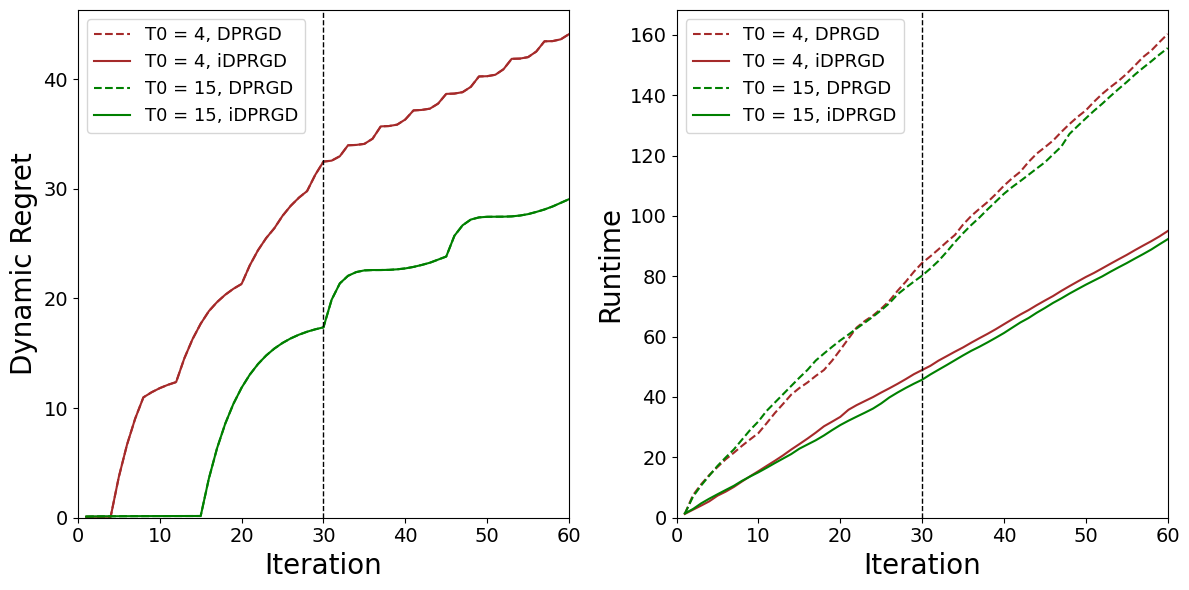

In [85]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

colors = ['brown', 'green', 'red']

ax = axs[0] 

for s in range(len(T0_candidate)):
    ax.plot(np.arange(1, T+1), dynamic_regret[s], label = 'T0 = ' + str(T0_candidate[s]) + ', DPRGD', linestyle = "--", color = colors[s])
    ax.plot(np.arange(1, T+1), dynamic_regret_iDPRGD[s], label = 'T0 = ' + str(T0_candidate[s]) + ', iDPRGD', linestyle = "-", color = colors[s])

ax.legend(fontsize = 13)
ax.set_xlabel('Iteration', fontsize = 20)
ax.set_ylabel('Dynamic Regret', fontsize = 20)
ax.set_ylim(0, None)
ax.set_xlim(0, 60)
ax.tick_params(axis = 'both', labelsize = 14)
ax.axvline(x = 30, color='black', linestyle='--', alpha = 1, lw = 1)

ax = axs[1] 

for s in range(len(T0_candidate)):
    ax.plot(np.arange(1, T+1), runtime[s], label = 'T0 = ' + str(T0_candidate[s]) + ', DPRGD', linestyle = '--', color = colors[s])
    ax.plot(np.arange(1, T+1), runtime_iDPRGD[s], label = 'T0 = ' + str(T0_candidate[s]) + ', iDPRGD', linestyle = '-', color = colors[s])

ax.legend(fontsize = 13)
ax.set_xlabel('Iteration', fontsize = 20)
ax.set_ylabel('Runtime', fontsize = 20)  
ax.set_ylim(0, None) 
ax.set_xlim(0, 60)
ax.tick_params(axis = 'both', labelsize = 14) 
ax.axvline(x = 30, color='black', linestyle='--', alpha = 1, lw = 1)

plt.tight_layout()
plt.savefig('figure/SPD.pdf')
plt.show()